In [32]:
from tz.osemosys import Model
import matplotlib.pyplot as plt

model = Model.from_yaml("../models/MDG/")
model.solve(solver="highs")

Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 321.25it/s]


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
16851 rows, 12630 cols, 365724 nonzeros
14274 rows, 11452 cols, 350545 nonzeros
Presolve : Reductions: rows 14274(-20709); columns 11452(-13328); elements 350545(-202871)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     9.5080315967e+03 Pr: 417(57774.3) 0s
      10500     1.9351143425e+04 Pr: 0(0); Du: 0(3.46463e-11) 1s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 10500
Objective value     :  1.9351143425e+04
HiGHS run time      :          1.92
Writing the solution to /private/var/folders/5w/6cly89qs6hxfqs39wgpz_53h0000gn/T/linopy-solve-adgwx7kk.sol


True

NameError: name 'plt' is not defined

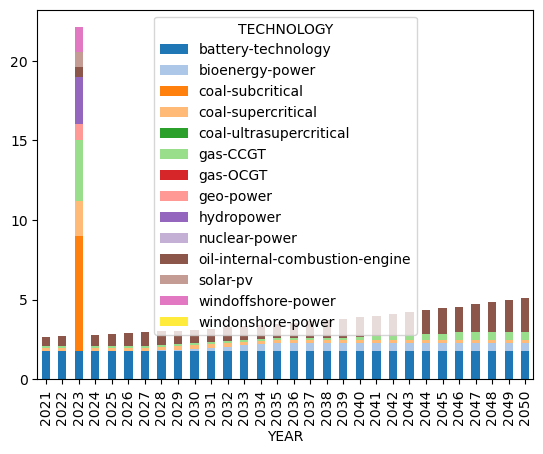

In [34]:
# Group the data by TECHNOLOGY and YEAR and calculate the sum of GrossCapacity
grouped_data = model.solution.GrossCapacity.to_dataframe().reset_index().groupby(by=["TECHNOLOGY", "YEAR"]).sum(numeric_only=True).reset_index()

# Exclude import, resource, production, and transmission results
grouped_data = grouped_data[~(grouped_data["TECHNOLOGY"].str.contains('|'.join(['step',
                                                                                'import',
                                                                                'resource',
                                                                                'production',
                                                                                'transmission',
                                                                                'liquefaction',
                                                                                'regasification'])))]

pivot_data = grouped_data.reset_index().pivot(index="YEAR", columns="TECHNOLOGY", values="GrossCapacity")

# Plot the data
color = ((0.12, 0.47, 0.71),
 (0.68, 0.78, 0.91),
 (1.0, 0.50, 0.05),
 (1.0, 0.73, 0.47),
 (0.17, 0.63, 0.17),
 (0.60, 0.87, 0.54),
 (0.84, 0.15, 0.16),
 (1.0, 0.60, 0.59),
 (0.58, 0.40, 0.74),
 (0.77, 0.69, 0.83),
 (0.55, 0.34, 0.29),
 (0.77, 0.61, 0.58),
 (0.89, 0.47, 0.76),
 (1.0, 0.92, 0.23), # solar = 'y'
 (0.50, 0.50, 0.50),
 (0.78, 0.78, 0.78),
 (0.74, 0.74, 0.13),
 (0.86, 0.86, 0.55),
 (0.09, 0.75, 0.81),
 (0.62, 0.85, 0.90))
pivot_data.plot(kind="bar", 
                stacked=True, 
                # color=plt.cm.tab20.colors)
                color = color)

# Set the labels and title
plt.xlabel("Year")
plt.ylabel("Gross Capacity (GW)")
plt.title("Capacity by technology and year")
plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5, -0.2),
          fancybox=True, 
          shadow=True, ncol=5)

# Show the plot
plt.show()



In [27]:
model.solution

<xarray.Dataset> Size: 2MB
Dimensions:                              (REGION: 1, YEAR: 28, TECHNOLOGY: 30,
                                          EMISSION: 3, STORAGE: 1, _REGION: 1,
                                          FUEL: 15, TIMESLICE: 12,
                                          MODE_OF_OPERATION: 8)
Coordinates:
  * REGION                               (REGION) <U3 12B 'MDG'
  * YEAR                                 (YEAR) int64 224B 2023 2024 ... 2050
  * TECHNOLOGY                           (TECHNOLOGY) <U30 4kB 'coal-hard-dom...
  * EMISSION                             (EMISSION) <U3 36B 'CO2' 'NOx' 'SOx'
  * STORAGE                              (STORAGE) <U15 60B 'battery-storage'
  * _REGION                              (_REGION) <U3 12B 'MDG'
  * FUEL                                 (FUEL) <U21 1kB 'coal-brown' ... 'se...
  * TIMESLICE                            (TIMESLICE) <U5 240B 's1-h1' ... 's2...
  * MODE_OF_OPERATION                    (MODE_OF_OPERATION) <U21 672B 'CHARG...
Data variables: (12/44)
    AnnualFixedOperatingCost             (REGION, TECHNOLOGY, YEAR) float64 7kB ...
    AnnualTechnologyEmission             (REGION, TECHNOLOGY, YEAR, EMISSION) float64 20kB ...
    AnnualVariableOperatingCost          (YEAR, REGION, TECHNOLOGY) float64 7kB ...
    CapitalInvestment                    (REGION, TECHNOLOGY, YEAR) float64 7kB ...
    CapitalInvestmentStorage             (REGION, YEAR, STORAGE) float64 224B ...
    CapitalInvestmentTrade               (REGION, YEAR, FUEL, _REGION) float64 3kB ...
    ...                                   ...
    TotalTechnologyModelPeriodActivity   (REGION, TECHNOLOGY) float64 240B 25...
    Use                                  (REGION, YEAR, FUEL, TIMESLICE) float64 40kB ...
    marginal_cost_of_demand              (REGION, YEAR, FUEL, TIMESLICE) float64 40kB ...
    marginal_cost_of_demand_annual       (REGION, YEAR, FUEL) float64 3kB 3.4...
    marginal_cost_of_emissions_annual    (REGION, YEAR, EMISSION) float64 672B ...
    marginal_cost_of_emissions_total     (REGION, EMISSION) float64 24B nan ....

In [28]:
( model
 ._m
 .solution
 .RateOfActivity
 .to_dataframe()
 .reset_index()
 .query(" MODE_OF_OPERATION.isin(['CHARGE', 'DISCHARGE'])")
 .query(" TECHNOLOGY == 'battery' ")
 .groupby(by='MODE_OF_OPERATION')
 .sum(numeric_only=True)
)

,YEAR,RateOfActivity
MODE_OF_OPERATION,,


In [29]:
model._m.solution.TradeAnnual.to_dataframe().reset_index().query("FUEL == 'secondary-electricity' ").TradeAnnual.describe()

AttributeError: 'Dataset' object has no attribute 'TradeAnnual'

In [ ]:
model._m.solution

In [ ]:
from tz.osemosys import Model

# run model
iso_code = 'PAK'
model = Model.from_yaml(f"../models/{iso_code}/")
model.solve()

In [ ]:
model.solution.RateOfActivity.to_dataframe()

In [ ]:
for i in list( model.solution.variables ):
    if 'Emission' in i:
        print(i)

In [ ]:
# plot generation
gen = (
    model
    .solution
    .Production
    .to_dataframe()
    .reset_index()
    .pivot_table(
        index='YEAR', 
        columns='REGION', 
        values='Production',
        aggfunc='sum',
    )
)

gen.plot()